# Construcción del Grafo Poblacional de Costa Rica a nivel Distrital
Este cuaderno carga datos geoespaciales y poblacionales para construir un grafo de distritos contiguos con sus respectivas poblaciones como peso nodal.

In [393]:
!pip install geopandas shapely networkx pandas matplotlib openpyxl


In [631]:
# Librerías 
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import SpectralClustering


In [633]:
# Cargar shapefile de distritos (UGED 2022)
# Tomado de: https://inec.cr/mapas-cartografia/unidad-geoestadistica-distrital-2022 

shapefile_path = "UGED_MGN_2022/UGED_MGN_2022.shp"
gdf_distritos = gpd.read_file(shapefile_path)
gdf_distritos = gdf_distritos[gdf_distritos.geometry.notnull()].copy()
gdf_distritos.set_crs(epsg=5367, inplace=True)  # CRS oficial de Costa Rica
gdf_distritos[['NOMB_UGED', 'COD_UGED', 'AREA_KM2']].head(15)

print(gdf_distritos.shape)

(492, 7)


In [635]:
# Cargar archivo principal (hoja 202x)
df_poblacion = pd.read_excel("repoblacev2011-2025-03_2.xlsx", sheet_name="2022", skiprows=7)

with pd.option_context('display.max_rows', None):
    display(df_poblacion)

Unnamed: 0                 Unnamed: 1  Unnamed: 2     0 - 4     5 - 9  \
0            NaN                        NaN         NaN       NaN       NaN   
1            NaN                 Costa Rica   5213362.0  360250.0  375884.0   
2            NaN                   San José   1685299.0  103537.0  110031.0   
3            NaN                   San José    351958.0   18646.0   20007.0   
4            NaN                     Carmen      2946.0      73.0      85.0   
5            NaN                     Merced     15408.0     778.0     826.0   
6            NaN                   Hospital     24030.0    1277.0    1383.0   
7            NaN                   Catedral     15682.0     643.0     719.0   
8            NaN                     Zapote     21990.0     923.0    1070.0   
9            NaN  San Francisco de Dos Ríos     23745.0     966.0    1129.0   
10           NaN                      Uruca     42861.0    2929.0    2933.0   
11           NaN               Mata Redonda     10119.0     387.0     421.0   
12           NaN                      Pavas     89531.0    5087.0    5398.0   
13           NaN                    Hatillo     60723.0    3250.0    3543.0   
14           NaN              San Sebastián     44923.0    2333.0    2500.0   
15           NaN                     Escazú     71202.0    4289.0    4567.0   
16           NaN                     Escazú     13752.0     788.0     819.0   
17           NaN                San Antonio     28329.0    1850.0    1971.0   
18           NaN                 San Rafael     29121.0    1651.0    1777.0   
19           NaN               Desamparados    249367.0   16335.0   17250.0   
20           NaN               Desamparados     37479.0    2147.0    2248.0   
21           NaN                 San Miguel     38716.0    2631.0    2803.0   
22           NaN           San Juan de Dios     24505.0    1731.0    1818.0   
23           NaN          San Rafael Arriba     18412.0    1156.0    1225.0   
24           NaN                San Antonio     11343.0     588.0     642.0   
25           NaN                    Frailes      4586.0     306.0     328.0   
26           NaN                    Patarrá     14919.0    1086.0    1106.0   
27           NaN              San Cristóbal      4769.0     347.0     356.0   
28           NaN                    Rosario      3787.0     269.0     276.0   
29           NaN                      Damas     15713.0     979.0    1026.0   
30           NaN           San Rafael Abajo     26781.0    1735.0    1787.0   
31           NaN                  Gravilias     17237.0     866.0     950.0   
32           NaN                  Los Guido     31120.0    2494.0    2685.0   
33           NaN                   Puriscal     38593.0    2181.0    2466.0   
34           NaN                   Santiago     12600.0     687.0     759.0   
35           NaN               Mercedes Sur      7099.0     396.0     452.0   
36           NaN                  Barbacoas      4486.0     268.0     293.0   
37           NaN                 Grifo Alto      1492.0      84.0     102.0   
38           NaN                 San Rafael      2009.0     102.0     127.0   
39           NaN                 Candelaria      1753.0     107.0     125.0   
40           NaN             Desamparaditos       794.0      39.0      52.0   
41           NaN                San Antonio      4720.0     282.0     317.0   
42           NaN                     Chires      3640.0     216.0     239.0   
43           NaN                    Tarrazú     18787.0    1541.0    1457.0   
44           NaN                 San Marcos     11365.0     909.0     889.0   
45           NaN                San Lorenzo      5250.0     435.0     393.0   
46           NaN                 San Carlos      2172.0     197.0     175.0   
47           NaN                     Aserrí     64480.0    4342.0    4595.0   
48           NaN                     Aserrí     30347.0    2003.0    2115.0   
49           NaN                    Tarbaca      1676.0 

In [637]:
# Cortar hasta la fila 574 para evitar duplicados por sexo
df_poblacion = df_poblacion.iloc[:567]

with pd.option_context('display.max_rows', None):
    display(df_poblacion)

Unnamed: 0                 Unnamed: 1  Unnamed: 2     0 - 4     5 - 9  \
0           NaN                        NaN         NaN       NaN       NaN   
1           NaN                 Costa Rica   5213362.0  360250.0  375884.0   
2           NaN                   San José   1685299.0  103537.0  110031.0   
3           NaN                   San José    351958.0   18646.0   20007.0   
4           NaN                     Carmen      2946.0      73.0      85.0   
5           NaN                     Merced     15408.0     778.0     826.0   
6           NaN                   Hospital     24030.0    1277.0    1383.0   
7           NaN                   Catedral     15682.0     643.0     719.0   
8           NaN                     Zapote     21990.0     923.0    1070.0   
9           NaN  San Francisco de Dos Ríos     23745.0     966.0    1129.0   
10          NaN                      Uruca     42861.0    2929.0    2933.0   
11          NaN               Mata Redonda     10119.0     387.0     421.0   
12          NaN                      Pavas     89531.0    5087.0    5398.0   
13          NaN                    Hatillo     60723.0    3250.0    3543.0   
14          NaN              San Sebastián     44923.0    2333.0    2500.0   
15          NaN                     Escazú     71202.0    4289.0    4567.0   
16          NaN                     Escazú     13752.0     788.0     819.0   
17          NaN                San Antonio     28329.0    1850.0    1971.0   
18          NaN                 San Rafael     29121.0    1651.0    1777.0   
19          NaN               Desamparados    249367.0   16335.0   17250.0   
20          NaN               Desamparados     37479.0    2147.0    2248.0   
21          NaN                 San Miguel     38716.0    2631.0    2803.0   
22          NaN           San Juan de Dios     24505.0    1731.0    1818.0   
23          NaN          San Rafael Arriba     18412.0    1156.0    1225.0   
24          NaN                San Antonio     11343.0     588.0     642.0   
25          NaN                    Frailes      4586.0     306.0     328.0   
26          NaN                    Patarrá     14919.0    1086.0    1106.0   
27          NaN              San Cristóbal      4769.0     347.0     356.0   
28          NaN                    Rosario      3787.0     269.0     276.0   
29          NaN                      Damas     15713.0     979.0    1026.0   
30          NaN           San Rafael Abajo     26781.0    1735.0    1787.0   
31          NaN                  Gravilias     17237.0     866.0     950.0   
32          NaN                  Los Guido     31120.0    2494.0    2685.0   
33          NaN                   Puriscal     38593.0    2181.0    2466.0   
34          NaN                   Santiago     12600.0     687.0     759.0   
35          NaN               Mercedes Sur      7099.0     396.0     452.0   
36          NaN                  Barbacoas      4486.0     268.0     293.0   
37          NaN                 Grifo Alto      1492.0      84.0     102.0   
38          NaN                 San Rafael      2009.0     102.0     127.0   
39          NaN                 Candelaria      1753.0     107.0     125.0   
40          NaN             Desamparaditos       794.0      39.0      52.0   
41          NaN                San Antonio      4720.0     282.0     317.0   
42          NaN                     Chires      3640.0     216.0     239.0   
43          NaN                    Tarrazú     18787.0    1541.0    1457.0   
44          NaN                 San Marcos     11365.0     909.0     889.0   
45          NaN                San Lorenzo      5250.0     435.0     393.0   
46          NaN                 San Carlos      2172.0     197.0     175.0   
47          NaN                     Aserrí     64480.0    4342.0    4595.0   
48          NaN                     Aserrí     30347.0    2003.0    2115.0   
49          NaN                    Tarbaca      1676.0     106.0     121.0   
50          NaN            

In [639]:
# Renombrar columnas
df_poblacion.rename(columns={df_poblacion.columns[1]: "Nombre", df_poblacion.columns[2]: "Total"}, inplace=True)

# Limpiar nulos y convertir población a numérico
df_poblacion = df_poblacion[df_poblacion["Nombre"].notnull() & df_poblacion["Total"].notnull()]
df_poblacion["Total"] = pd.to_numeric(df_poblacion["Total"], errors='coerce')

# Eliminar provincias explícitamente
provincias = ["Costa Rica", "San José", "Alajuela", "Cartago", "Heredia", "Guanacaste", "Puntarenas", "Limón"]
df_poblacion = df_poblacion[~df_poblacion["Nombre"].isin(provincias)]

# Cargar cantones y eliminar sus nombres del dataframe principal
df_cantones = pd.read_excel("Cantones.xlsx", sheet_name="Cantones")
nombres_cantones = df_cantones["CANTÓN"].dropna().unique()
df_distritos = df_poblacion[~df_poblacion["Nombre"].isin(nombres_cantones)].copy()

# Resultado final
df_distritos = df_distritos[["Nombre", "Total"]].reset_index(drop=True)

# Mostrar resumen
print(df_distritos.head(10))
print("Distritos válidos:", df_distritos.shape[0])


                      Nombre    Total
0                     Carmen   2946.0
1                     Merced  15408.0
2                   Hospital  24030.0
3                   Catedral  15682.0
4                     Zapote  21990.0
5  San Francisco de Dos Ríos  23745.0
6                      Uruca  42861.0
7               Mata Redonda  10119.0
8                      Pavas  89531.0
9                    Hatillo  60723.0
Distritos válidos: 396


In [641]:
with pd.option_context('display.max_rows', None):
    display(df_distritos)

Nombre    Total
0                       Carmen   2946.0
1                       Merced  15408.0
2                     Hospital  24030.0
3                     Catedral  15682.0
4                       Zapote  21990.0
5    San Francisco de Dos Ríos  23745.0
6                        Uruca  42861.0
7                 Mata Redonda  10119.0
8                        Pavas  89531.0
9                      Hatillo  60723.0
10               San Sebastián  44923.0
11                 San Antonio  28329.0
12                  San Miguel  38716.0
13            San Juan de Dios  24505.0
14           San Rafael Arriba  18412.0
15                 San Antonio  11343.0
16                     Frailes   4586.0
17                     Patarrá  14919.0
18               San Cristóbal   4769.0
19                     Rosario   3787.0
20                       Damas  15713.0
21            San Rafael Abajo  26781.0
22                   Gravilias  17237.0
23                   Los Guido  31120.0
24                    Santiago  12600.0
25                Mercedes Sur   7099.0
26                   Barbacoas   4486.0
27                  Grifo Alto   1492.0
28                  Candelaria   1753.0
29              Desamparaditos    794.0
30                 San Antonio   4720.0
31                      Chires   3640.0
32                  San Marcos  11365.0
33                 San Lorenzo   5250.0
34                     Tarbaca   1676.0
35             Vuelta de Jorco   7342.0
36                 San Gabriel   6930.0
37                       Legua   1748.0
38                   Monterrey    558.0
39                 Salitrillos  15879.0
40                       Colón  17411.0
41                     Guayabo   5414.0
42                    Tabarcia   5160.0
43              Piedras Negras    498.0
44                    Picagres    899.0
45                       Jaris   1377.0
46                   Guadalupe  22347.0
47               San Francisco   2421.0
48               Calle Blancos  23451.0
49             Mata de Plátano  21198.0
50                        Ipís  32049.0
51              Rancho Redondo   3224.0
52                      Purral  36074.0
53                    Salitral   5587.0
54                       Pozos  20671.0
55                       Uruca   9129.0
56                    Piedades  10263.0
57                      Brasil   3247.0
58                San Josecito  13069.0
59                 San Antonio   6003.0
60                  Concepción  23455.0
61                  San Felipe  41306.0
62       Dulce Nombre de Jesús  12149.0
63                   Patalillo  24907.0
64                    Cascajal   8602.0
65                 San Ignacio   9475.0
66                     Guaitil   2685.0
67                   Palmichal   5308.0
68                   Cangrejal   2121.0
69                  Sabanillas   2668.0
70                    San Juan  25866.0
71              Cinco Esquinas   8617.0
72            Anselmo Llorente  12913.0
73                   León XIII  20551.0
74                      Colima  18118.0
75                 San Vicente  32041.0
76                San Jerónimo   7463.0
77                    Trinidad  23755.0
78                   San Pedro  28844.0
79                   Sabanilla  14082.0
80                    Mercedes   6086.0
81                   San Pedro    861.0
82            San Juan de Mata   1546.0
83                    San Luis    721.0
84                      Carara   2330.0
85                 Santa María   5251.0
86                      Jardín    702.0
87                       Copey   2088.0
88                  Granadilla  19207.0
89                     Sánchez   6833.0
90                    Tirrases  22032.0
91    San Isidro de El General  48435.0
92                     General   6873.0
93               Daniel Flores  35584.0
94                       Rivas   7318.0
95                   San Pedro   9344.0
96                  Platanares   7497.0
97                    Pejibaye   7972.0
98                       Cajón   9045.0
99                      

In [525]:
# Datos estadísticos de los distritos
df_distritos.describe()

Total
count    396.000000
mean   10026.477273
std    10753.505160
min      380.000000
25%     3018.500000
50%     6739.000000
75%    12325.250000
max    89531.000000

In [527]:
media = df_distritos["Total"].mean()
desviacion = df_distritos["Total"].std()
mediana = df_distritos["Total"].median()
minimo = df_distritos["Total"].min()
maximo = df_distritos["Total"].max()

print(f"Media: {media:,.0f}")
print(f"Desviación estándar: {desviacion:,.0f}")
print(f"Mediana: {mediana:,.0f}")
print(f"Mínimo: {minimo:,.0f}")
print(f"Máximo: {maximo:,.0f}")

Media: 10,026
Desviación estándar: 10,754
Mediana: 6,739
Mínimo: 380
Máximo: 89,531


In [529]:
# Localizar distrito con el valor máximo
distrito_max = df_distritos[df_distritos["Total"] == df_distritos["Total"].max()]
print(distrito_max)

  Nombre    Total
8  Pavas  89531.0


In [531]:
# Normalizar nombres para asegurar coincidencias
gdf_distritos["NOMB_UGED_clean"] = gdf_distritos["NOMB_UGED"].str.strip().str.upper()
df_poblacion["Nombre_clean"] = df_poblacion["Nombre"].str.strip().str.upper()

# Unir por nombres limpios
gdf = gdf_distritos.merge(df_poblacion, left_on="NOMB_UGED_clean", right_on="Nombre_clean", how="left")
gdf = gdf.dropna(subset=["Total"])
gdf = gdf.set_index("COD_UGED")
gdf

# # Unir por nombres limpios
# gdf = gdf_distritos.merge(df_poblacion, left_on="NOMB_UGED", right_on="Nombre", how="left")
# gdf = gdf.dropna(subset=["Total"])
# gdf = gdf.set_index("COD_UGED")
# gdf

ID NOMB_UGEP NOMB_UGEC NOMB_UGED  AREA_KM2  \
COD_UGED                                                
10101       1  SAN JOSE  SAN JOSE    CARMEN      1.50   
10101       1  SAN JOSE  SAN JOSE    CARMEN      1.50   
10102       2  SAN JOSE  SAN JOSE    MERCED      2.30   
10103       3  SAN JOSE  SAN JOSE  HOSPITAL      3.34   
10104       4  SAN JOSE  SAN JOSE  CATEDRAL      2.41   
...       ...       ...       ...       ...       ...   
70602     489     LIMON   GUACIMO  MERCEDES     90.30   
70602     489     LIMON   GUACIMO  MERCEDES     90.30   
70602     489     LIMON   GUACIMO  MERCEDES     90.30   
70602     489     LIMON   GUACIMO  MERCEDES     90.30   
70603     490     LIMON   GUACIMO    POCORA     73.97   

                                                   geometry NOMB_UGED_clean  \
COD_UGED                                                                      
10101     POLYGON ((492798.4 1099069.69, 492804.97 10990...          CARMEN   
10101     POLYGON ((492798.4 1099069.69, 492804.97 10990...          CARMEN   
10102     POLYGON ((491397.73 1099285.2, 491384.97 10991...          MERCED   
10103     POLYGON ((489133.52 1097516.62, 489126.81 1097...        HOSPITAL   
10104     POLYGON ((491112.51 1096945.7, 491135.42 10970...        CATEDRAL   
...                                                     ...             ...   
70602     POLYGON ((545964.81 1131691.9, 545955.03 11316...        MERCEDES   
70602     POLYGON ((545964.81 1131691.9, 545955.03 11316...        MERCEDES   
70602     POLYGON ((545964.81 1131691.9, 545955.03 11316...        MERCEDES   
70602     POLYGON ((545964.81 1131691.9, 545955.03 11316...        MERCEDES   
70603     POLYGON ((549791.93 1130646.89, 549789.41 1130...          POCORA   

          Unnamed: 0    Nombre    Total  ...  35 - 39  40 - 44  45 - 49  \
COD_UGED                                 ...                              
10101            NaN    Carmen   2946.0  ...    377.0    332.0    262.0   
10101            NaN    Carmen  19390.0  ...   1725.0   1480.0   1252.0   
10102            NaN    Merced  15408.0  ...   1390.0   1226.0    995.0   
10103            NaN  Hospital  24030.0  ...   2128.0   1882.0   1529.0   
10104            NaN  Catedral  15682.0  ...   1595.0   1411.0   1145.0   
...              ...       ...      ...  ...      ...      ...      ...   
70602            NaN  Mercedes   6086.0  ...    574.0    512.0    386.0   
70602            NaN  Mercedes   3832.0  ...    299.0    262.0    232.0   
70602            NaN  Mercedes  30276.0  ...   2886.0   2543.0   2103.0   
70602            NaN  Mercedes   2357.0  ...    189.0    170.0    149.0   
70603            NaN    Pocora   8494.0  ...    632.0    567.0    495.0   

          50 - 54  55 - 59  60 - 64  65 - 69  70 - 74  75 y más  Nombre_clean  
COD_UGED                                                                       
10101       225.0    220.0    196.0    157.0    105.0     192.0        CARMEN  
10101      1181.0   1195.0   1042.0    816.0    543.0     796.0        CARMEN  
10102       895.0    915.0    851.0    703.0    499.0     759.0        MERCED  
10103      1373.0   1401.0   1306.0   1076.0    763.0    1165.0      HOSPITAL  
10104      1029.0   1051.0    980.0    808.0    573.0     878.0      CATEDRAL  
...           ...      ...      ...      ...      ...       ...           ...  
70602       334.0    363.0    367.0    324.0    231.0     338.0      MERCEDES  
70602       229.0    221.0    193.0    166.0    127.0     186.0      MERCEDES  
70602      1915.0   1923.0   1698.0   1332.0    898.0    1196.0      MERCEDES  
70602       134.0    124.0     98.0     68.0     44.0      62.0      MERCEDES  
70603       451.0    412.0    328.0    228.0    149.0     209.0        POCORA  

[893 rows x 27 columns]

In [533]:
# Crear grafo de contigüidad
G = nx.Graph()

# Agregar nodos con población
for idx, row in gdf.iterrows():
    G.add_node(idx, nombre=row['NOMB_UGED'], poblacion=row['Total'])

# Agregar aristas entre distritos contiguos
for i, geom in gdf.geometry.items():
    vecinos = gdf[gdf.geometry.touches(geom)].index
    for v in vecinos:
        if not G.has_edge(i, v):
            G.add_edge(i, v)


## Visualización del Grafo y Métricas

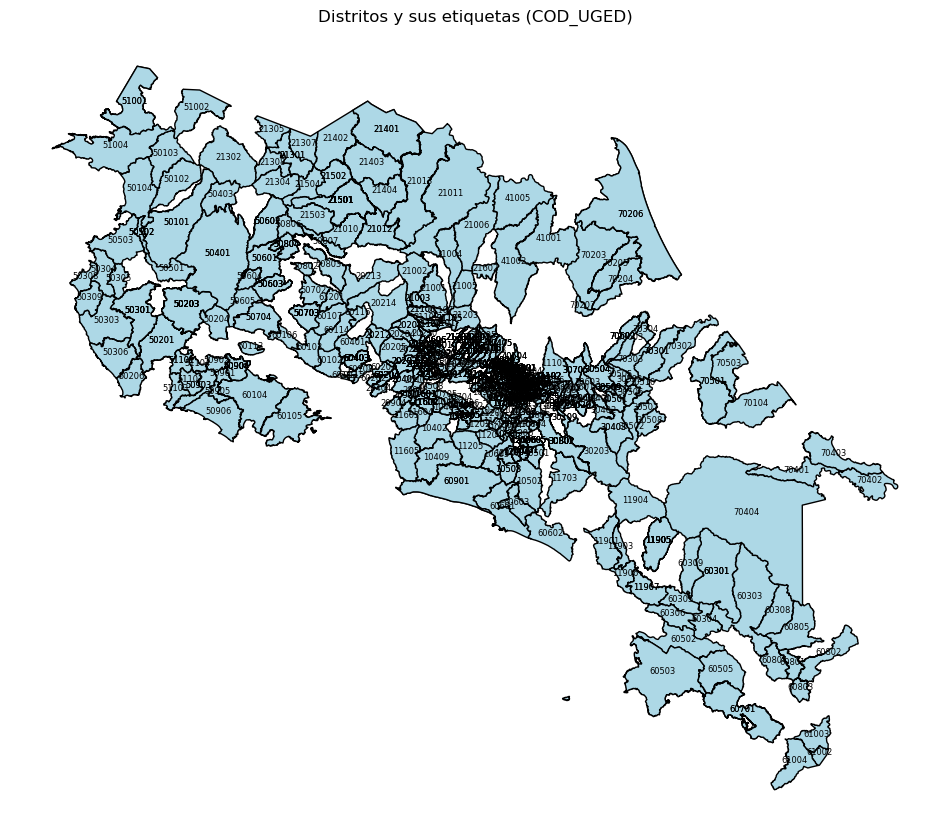

In [539]:
# Visualización del grafo sobre el mapa
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, color='lightblue', edgecolor='black')
for i, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=6, ha='center')
plt.title('Distritos y sus etiquetas (COD_UGED)')
plt.axis('off')
plt.show()

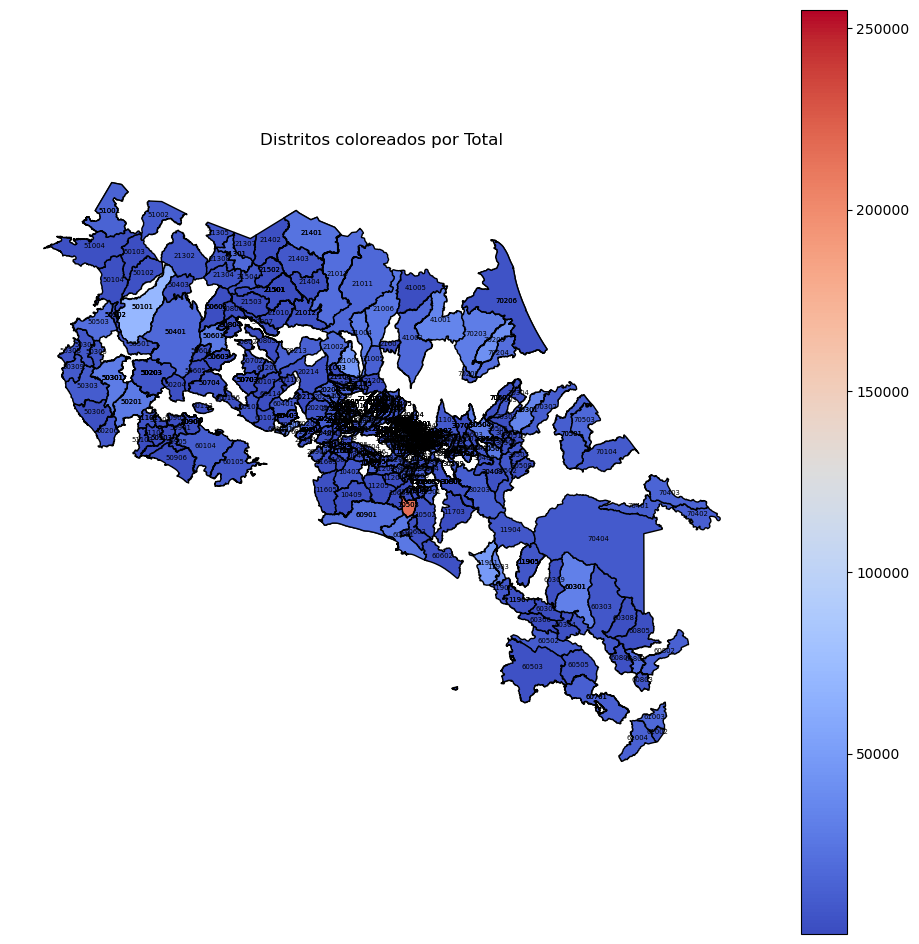

In [406]:
# (Opcional) Calcular densidad si tenemos área
# gdf["densidad"] = gdf["Total"] / gdf.geometry.area

# Si solo queremos población para color:
columna_color = "Total"  # O "densidad" si la calculas

# Crear visualización con colormap
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, column=columna_color, cmap='coolwarm', edgecolor='black', legend=True)

# Añadir etiquetas por distrito (opcional)
for i, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=5, ha='center')

plt.title(f'Distritos coloreados por {columna_color}')
plt.axis('off')
plt.show()

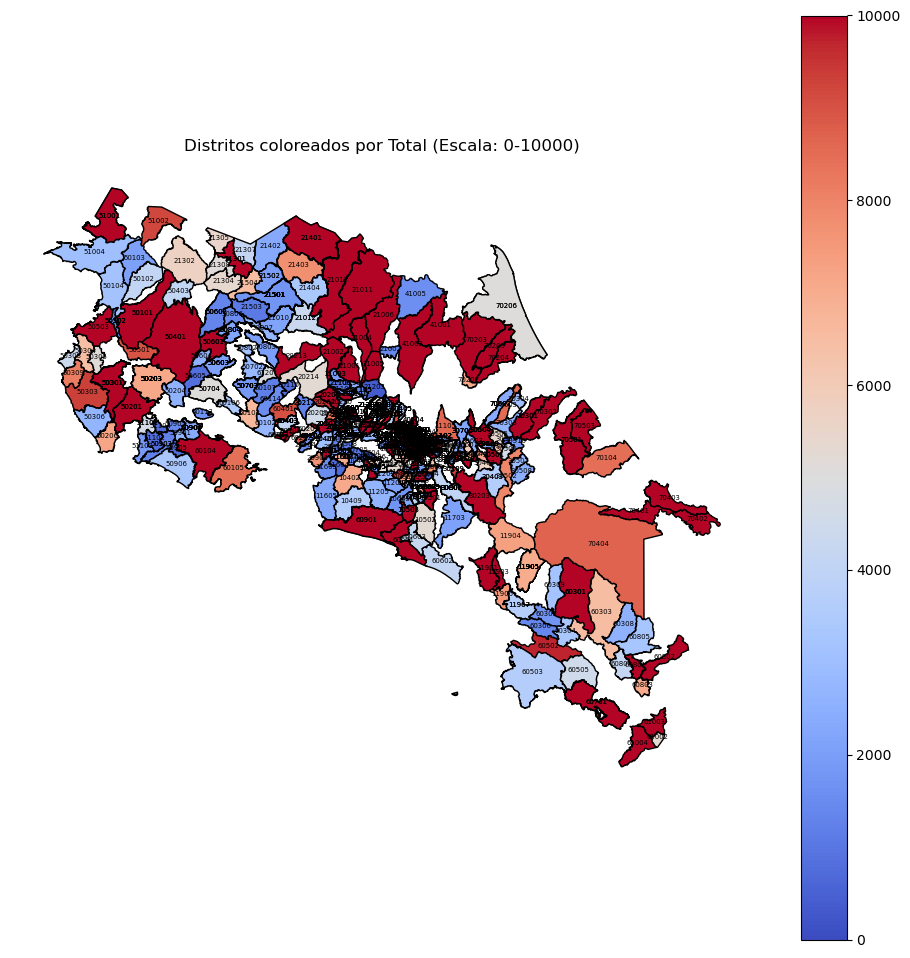

In [541]:
# Definir rango deseado para los colores
vmin = 0
vmax = 10000

# Visualización con escala personalizada
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(
    ax=ax,
    column=columna_color,
    cmap='coolwarm',
    edgecolor='black',
    legend=True,
    vmin=vmin,
    vmax=vmax
)

# Añadir etiquetas por distrito
for i, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(i), fontsize=5, ha='center')

plt.title(f'Distritos coloreados por {columna_color} (Escala: {vmin}-{vmax})')
plt.axis('off')
plt.show()


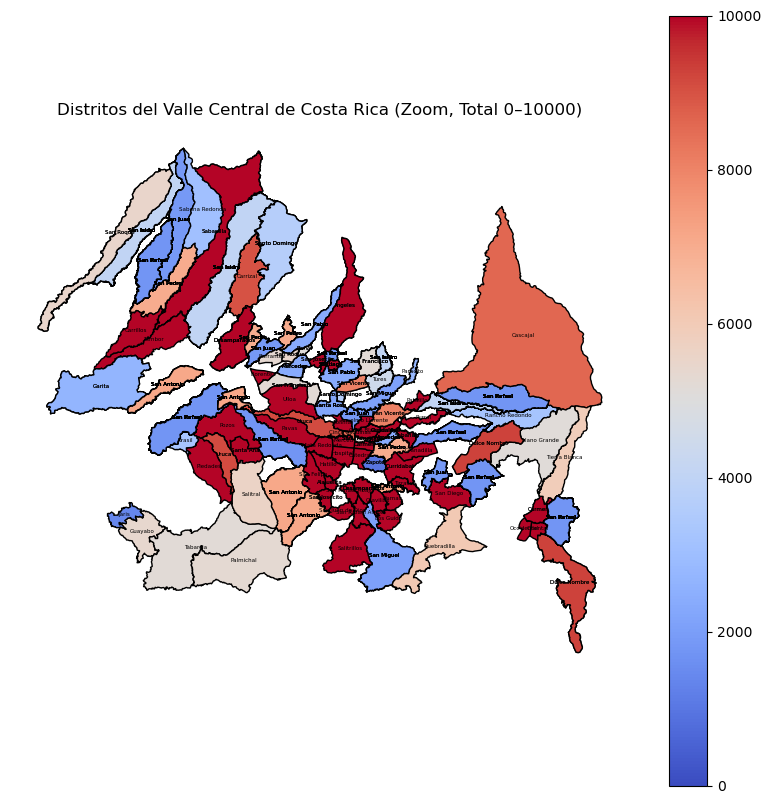

In [543]:
# Asegurar que estamos en la proyección correcta
gdf = gdf.to_crs(epsg=5367)

# Recorte espacial: Bounding Box aproximada para el Valle Central
gdf_valle = gdf.cx[470000:510000, 1090000:1125000]

# Visualizar solo los distritos del Valle Central con escala fija
fig, ax = plt.subplots(figsize=(10, 10))
gdf_valle.plot(
    ax=ax,
    column='Total',
    cmap='coolwarm',
    edgecolor='black',
    legend=True,
    vmin=0,
    vmax=10000
)

# Añadir etiquetas opcionales
for i, row in gdf_valle.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, str(row["Nombre"]), fontsize=4, ha='center')

plt.title("Distritos del Valle Central de Costa Rica (Zoom, Total 0–10000)")
plt.axis('off')
plt.show()


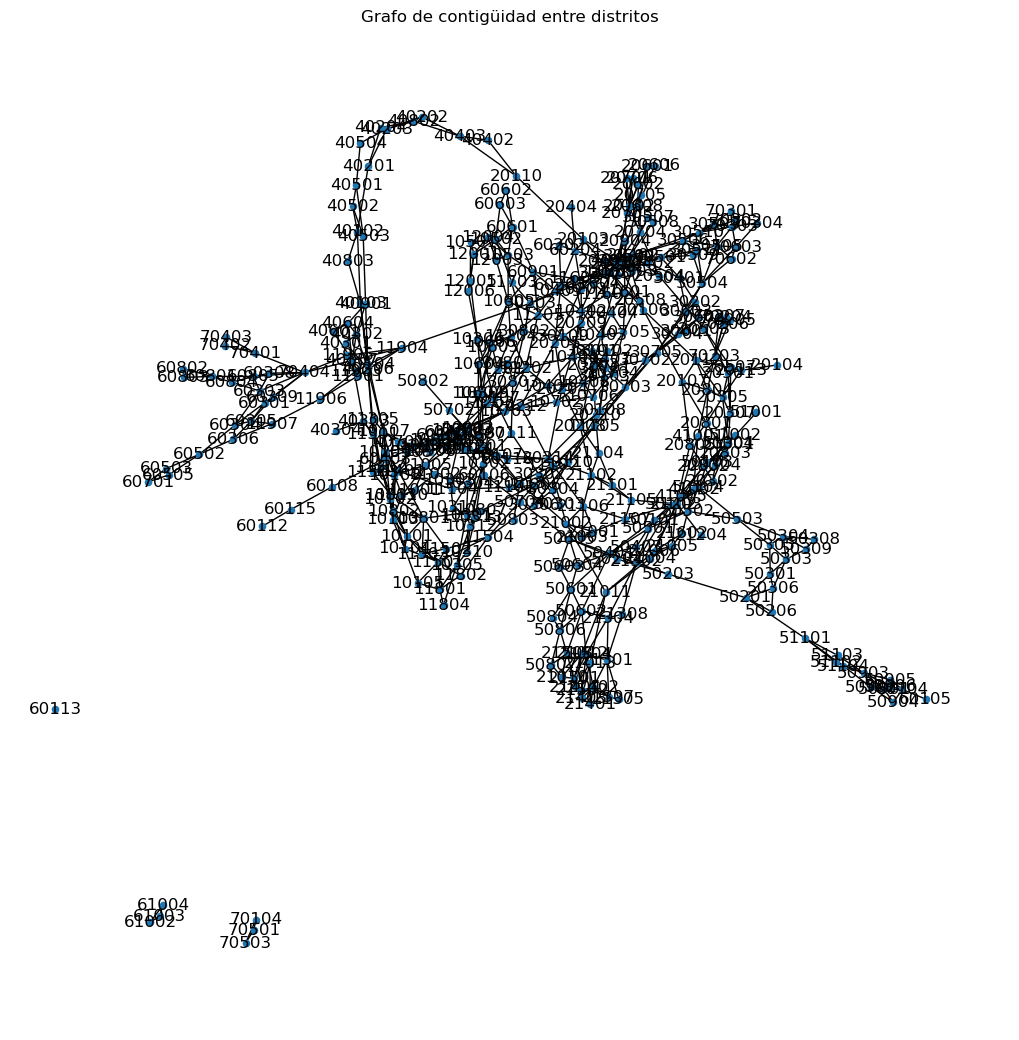

In [553]:
# Visualizar el grafo de contigüidad (sin base geográfica)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=20, with_labels=True)
plt.title('Grafo de contigüidad entre distritos')
plt.show()

In [410]:
# import matplotlib.pyplot as plt
# import networkx as nx

# plt.figure(figsize=(10, 10))

# # Ajustar parámetros del layout
# pos = nx.spring_layout(G, seed=42, k=0.05, iterations=100)

# # Dibujar grafo
# nx.draw(G, pos, node_size=30, with_labels=False)

# plt.title('Grafo de contigüidad entre distritos (ajustado)')
# plt.show()


In [555]:
# Métricas del grafo
print(f'Número de nodos: {G.number_of_nodes()}')
print(f'Número de aristas: {G.number_of_edges()}')
grados = [d for _, d in G.degree()]
print(f'Grado medio: {sum(grados)/len(grados):.2f}')
print(f'Número de componentes conexas: {nx.number_connected_components(G)}')

Número de nodos: 354
Número de aristas: 748
Grado medio: 4.23
Número de componentes conexas: 4


## Métricas de Evaluación de Distritos

### 1. Desviación estándar de la población
Esto permite evaluar qué tan equitativos son los distritos en términos de carga poblacional.

In [557]:
# import numpy as np

poblaciones = [data['poblacion'] for _, data in G.nodes(data=True)]
media_pob = np.mean(poblaciones)
desviacion = np.std(poblaciones)
print(f"Promedio de población por distrito: {media_pob:.2f}")
print(f"Desviación estándar poblacional: {desviacion:.2f}")

Promedio de población por distrito: 9831.71
Desviación estándar poblacional: 14915.65


### 2. Verificación de contigüidad
Cada distrito debe formar parte de un grafo conexo. Aquí verificamos si el grafo total tiene más de una componente conexa.

In [559]:
componentes = list(nx.connected_components(G))
print(f"Número de componentes conexas: {len(componentes)}")
if len(componentes) == 1:
    print("Todos los distritos están contiguamente conectados.")
else:
    print("Advertencia: hay distritos desconectados.")

Número de componentes conexas: 4
Advertencia: hay distritos desconectados.


### 3. Índice de Polsby-Popper (Compacidad)
Este índice mide cuán compacto es un distrito según su forma geométrica. El valor ideal es cercano a 1 (circular).

$$
\text{Polsby-Popper} = \frac{4\pi \cdot A}{P^2}
$$

donde:

- $A$ es el área del distrito,
- $P$ es el perímetro del distrito.

Este índice toma valores en el intervalo $(0,1]$, siendo **1** la forma más compacta (un círculo perfecto).


In [561]:
def polsby_popper(geom):
    if geom and geom.area > 0 and geom.length > 0:
        return (4 * np.pi * geom.area) / (geom.length ** 2)
    return 0

gdf['polsby_popper'] = gdf.geometry.apply(polsby_popper)
gdf[['NOMB_UGED', 'polsby_popper']].sort_values(by='polsby_popper', ascending=True).head(20)

NOMB_UGED  polsby_popper
COD_UGED                          
50807        ARENAL       0.067774
21204     SAN PEDRO       0.089009
21204     SAN PEDRO       0.089009
21204     SAN PEDRO       0.089009
21204     SAN PEDRO       0.089009
21204     SAN PEDRO       0.089009
21204     SAN PEDRO       0.089009
21204     SAN PEDRO       0.089009
60105       PAQUERA       0.092599
21013       POCOSOL       0.093737
60701       GOLFITO       0.098137
60701       GOLFITO       0.098137
20304     SAN ROQUE       0.113730
20304     SAN ROQUE       0.113730
60104       LEPANTO       0.124233
10309       ROSARIO       0.127916
10309       ROSARIO       0.127916
70603        POCORA       0.131558
10107         URUCA       0.131881
10107         URUCA       0.131881

##  ¿Cuántos distritos $k$ proponer?

In [563]:
# Procedemos a analizar con detalle para el problema de distritacion politica (PDP)

# Calcula el coeficiente de variación poblacional
cv = gdf["Total"].std() / gdf["Total"].mean()
print(cv)

1.3662444795488882


In [569]:
# Añade la columna Polsby_Popper:
gdf["area"] = gdf.geometry.area
gdf["perimeter"] = gdf.geometry.length
gdf["polsby_popper"] = (4 * np.pi * gdf["area"]) / (gdf["perimeter"] ** 2)

gdf.head()


ID NOMB_UGEP NOMB_UGEC NOMB_UGED  AREA_KM2  \
COD_UGED                                               
10101      1  SAN JOSE  SAN JOSE    CARMEN      1.50   
10101      1  SAN JOSE  SAN JOSE    CARMEN      1.50   
10102      2  SAN JOSE  SAN JOSE    MERCED      2.30   
10103      3  SAN JOSE  SAN JOSE  HOSPITAL      3.34   
10104      4  SAN JOSE  SAN JOSE  CATEDRAL      2.41   

                                                   geometry NOMB_UGED_clean  \
COD_UGED                                                                      
10101     POLYGON ((492798.4 1099069.69, 492804.97 10990...          CARMEN   
10101     POLYGON ((492798.4 1099069.69, 492804.97 10990...          CARMEN   
10102     POLYGON ((491397.73 1099285.2, 491384.97 10991...          MERCED   
10103     POLYGON ((489133.52 1097516.62, 489126.81 1097...        HOSPITAL   
10104     POLYGON ((491112.51 1096945.7, 491135.42 10970...        CATEDRAL   

          Unnamed: 0    Nombre    Total  ...  50 - 54  55 - 59  60 - 64  \
COD_UGED                                 ...                              
10101            NaN    Carmen   2946.0  ...    225.0    220.0    196.0   
10101            NaN    Carmen  19390.0  ...   1181.0   1195.0   1042.0   
10102            NaN    Merced  15408.0  ...    895.0    915.0    851.0   
10103            NaN  Hospital  24030.0  ...   1373.0   1401.0   1306.0   
10104            NaN  Catedral  15682.0  ...   1029.0   1051.0    980.0   

          65 - 69  70 - 74  75 y más  Nombre_clean  polsby_popper  \
COD_UGED                                                            
10101       157.0    105.0     192.0        CARMEN       0.514917   
10101       816.0    543.0     796.0        CARMEN       0.514917   
10102       703.0    499.0     759.0        MERCED       0.349236   
10103      1076.0    763.0    1165.0      HOSPITAL       0.558835   
10104       808.0    573.0     878.0      CATEDRAL       0.457425   

                  area    perimeter  
COD_UGED                             
10101     1.491562e+06  6033.331718  
10101     1.491562e+06  6033.331718  
10102     2.287468e+06  9072.414295  
10103     3.328674e+06  8651.647360  
10104     2.398433e+06  8117.245418  

[5 rows x 30 columns]

In [571]:
# Verifica contigüidad
G = nx.Graph()
for i, geom_i in gdf.geometry.items():
    G.add_node(i)
    for j, geom_j in gdf.geometry.items():
        if i != j and geom_i.touches(geom_j):
            G.add_edge(i, j)
            
componentes = list(nx.connected_components(G))
distritos_multiples = [c for c in componentes if len(c) < 2]


In [575]:
# k optimo
pob_total = gdf["Total"].sum()
pob_por_distrito = 89474  # promedio nacional por diputado
k = int(round(pob_total / pob_por_distrito))
print(k)


141


## Módulo de Redistribución Electoral tipo 'Caso Alemán' para Costa Rica

In [578]:
# Paso 1: Estimar número óptimo de distritos uninominales
poblacion_total = gdf['Total'].sum()
meta_poblacional = 89474  # objetivo basado en diputados actuales
k = round(poblacion_total / meta_poblacional)
print(f'Número estimado de distritos (k): {k}')

Número estimado de distritos (k): 141


In [580]:
# Calcular centroides y extraer coordenadas
gdf["centroid"] = gdf.geometry.centroid
gdf["x"] = gdf["centroid"].x
gdf["y"] = gdf["centroid"].y


In [582]:
coords = gdf[['x', 'y']].values


<Axes: >

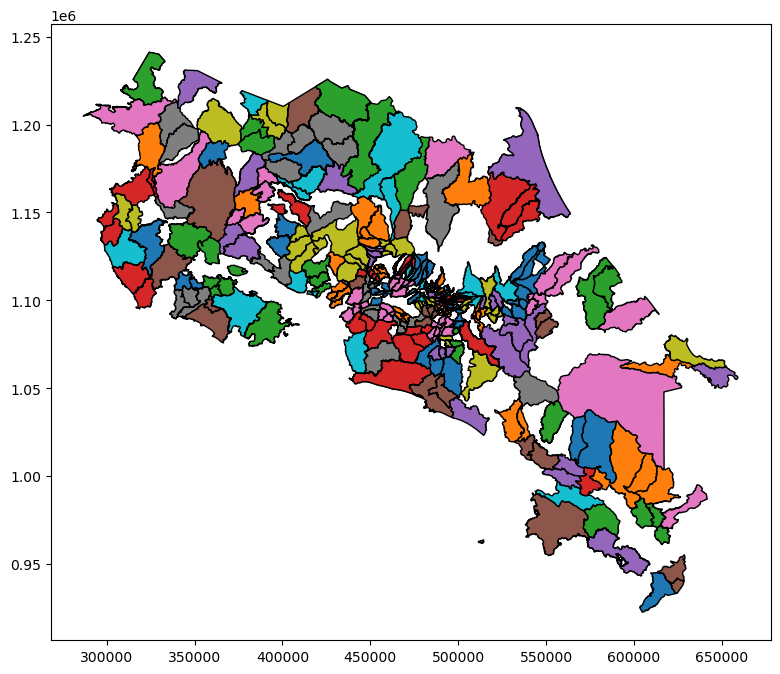

In [584]:
# Paso 2: Aplicar K-means usando coordenadas geográficas
# from sklearn.cluster import KMeans

coords = gdf[['x', 'y']].values
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(coords)
gdf['DistritoNuevo'] = kmeans.labels_

gdf.plot(column='DistritoNuevo', categorical=True, figsize=(10,8), legend=False, edgecolor='k')

In [586]:
# Paso 3: Evaluar población por nuevo distrito
agrupado = gdf.groupby('DistritoNuevo')['Total'].agg(['count', 'sum']).rename(columns={'count': 'NumDistritos', 'sum': 'Poblacion'})
agrupado['Desviacion_%'] = 100 * (agrupado['Poblacion'] - meta_poblacional) / meta_poblacional
agrupado.sort_values(by='Poblacion')

NumDistritos  Poblacion  Desviacion_%
DistritoNuevo                                       
110                       1     1092.0    -98.779534
84                        1     1598.0    -98.214006
18                        2     1778.0    -98.012831
124                       1     2088.0    -97.666361
137                       1     2330.0    -97.395892
...                     ...        ...           ...
21                       30   430822.0    381.505242
122                      19   456680.0    410.405257
131                      19   483881.0    440.806268
48                       38   508974.0    468.851286
22                       20   727557.0    713.149071

[141 rows x 3 columns]

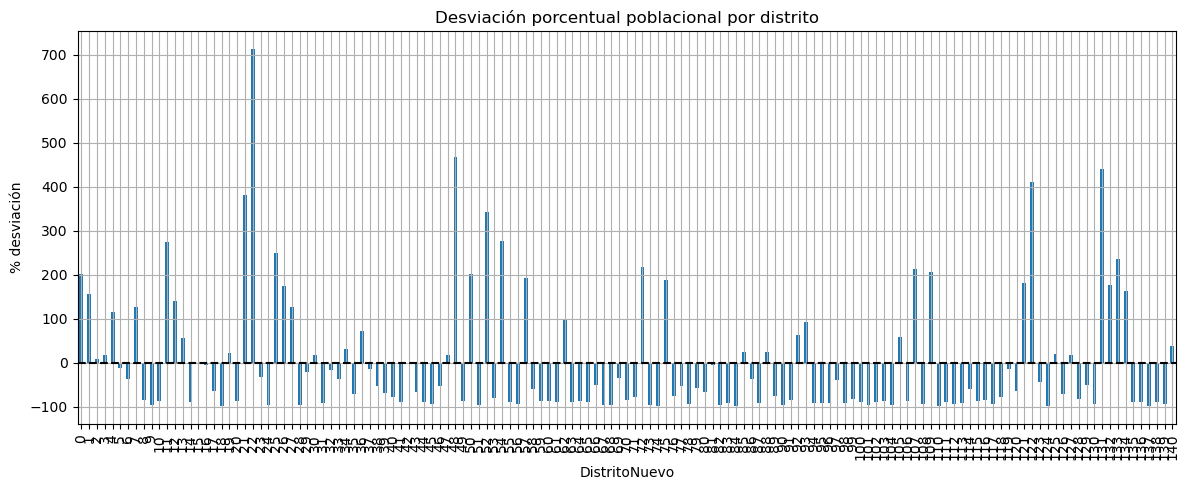

In [588]:
# Paso 4: Visualización de desviación poblacional

agrupado['Desviacion_%'].plot(kind='bar', figsize=(12,5), title='Desviación porcentual poblacional por distrito')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('% desviación')
plt.grid(True)
plt.tight_layout()
plt.show()

## Clustering con DBSCAN ponderado por densidad poblacional

In [590]:
# Paso 1: Asegurarse de tener coordenadas x, y de centroides
gdf['centroid'] = gdf.geometry.centroid
gdf['x'] = gdf['centroid'].x
gdf['y'] = gdf['centroid'].y
coords = gdf[['x', 'y']].values

In [592]:
# Paso 2: Normalizar coordenadas
# from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

<Axes: >

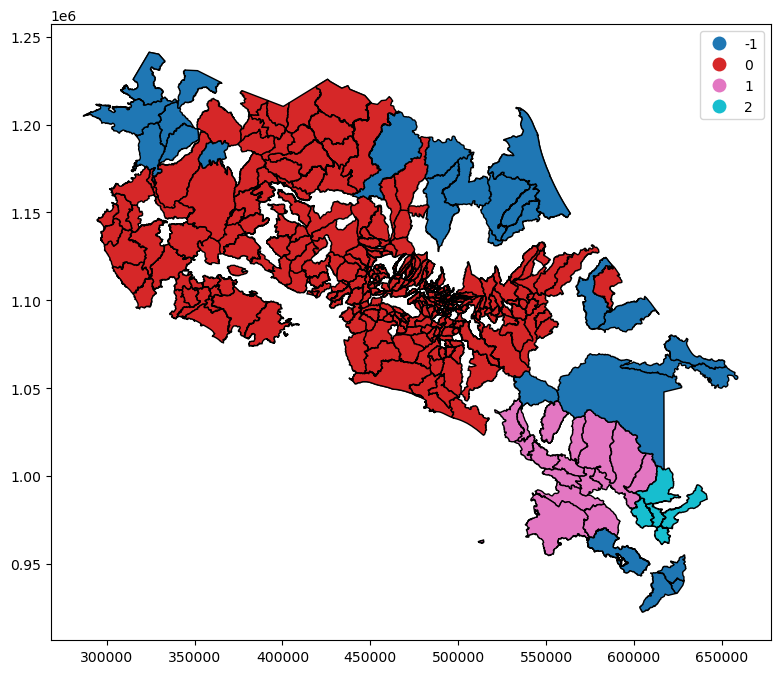

In [434]:
# Paso 3: Aplicar DBSCAN considerando densidad poblacional como pesos
from sklearn.cluster import DBSCAN

# DBSCAN requiere definir eps (radio) y min_samples (núcleo mínimo)
dbscan = DBSCAN(eps=0.5, min_samples=5)
gdf['DBSCAN_cluster'] = dbscan.fit_predict(coords_scaled)

gdf.plot(column='DBSCAN_cluster', categorical=True, figsize=(10,8), legend=True, edgecolor='k')

In [435]:
# Paso 4: Evaluar agrupaciones por población total
agrupado_dbscan = gdf.groupby('DBSCAN_cluster')['Total'].agg(['count', 'sum']).rename(columns={'count': 'NumDistritos', 'sum': 'Poblacion'})
agrupado_dbscan = agrupado_dbscan.sort_values(by='Poblacion', ascending=False)
agrupado_dbscan

NumDistritos   Poblacion
DBSCAN_cluster                          
 0                       833  12104072.0
-1                        31    468105.0
 1                        24    308611.0
 2                         5     44220.0

## Partición de Grafo por Clustering Espectral (Spectral Clustering)

In [598]:
# Paso 1: Crear matriz de adyacencia ponderada por proximidad y población
# from sklearn.preprocessing import normalize
# from sklearn.cluster import SpectralClustering
# import numpy as np
# import networkx as nx

gdf = gdf.reset_index(drop=True)


G = nx.Graph()
G.add_nodes_from(gdf.index)
for i, geom_i in gdf.geometry.items():
    for j, geom_j in gdf.geometry.items():
        if i < j and geom_i.touches(geom_j):
            pop_diff = abs(gdf.loc[i, 'Total'] - gdf.loc[j, 'Total']) + 1
            weight = 1 / pop_diff
            G.add_edge(i, j, weight=weight)

A = nx.to_numpy_array(G, nodelist=gdf.index, weight='weight')

In [600]:
# Paso 2: Aplicar Clustering Espectral
spectral = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='kmeans', random_state=42)
gdf['Distrito_Spectral'] = spectral.fit_predict(A)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


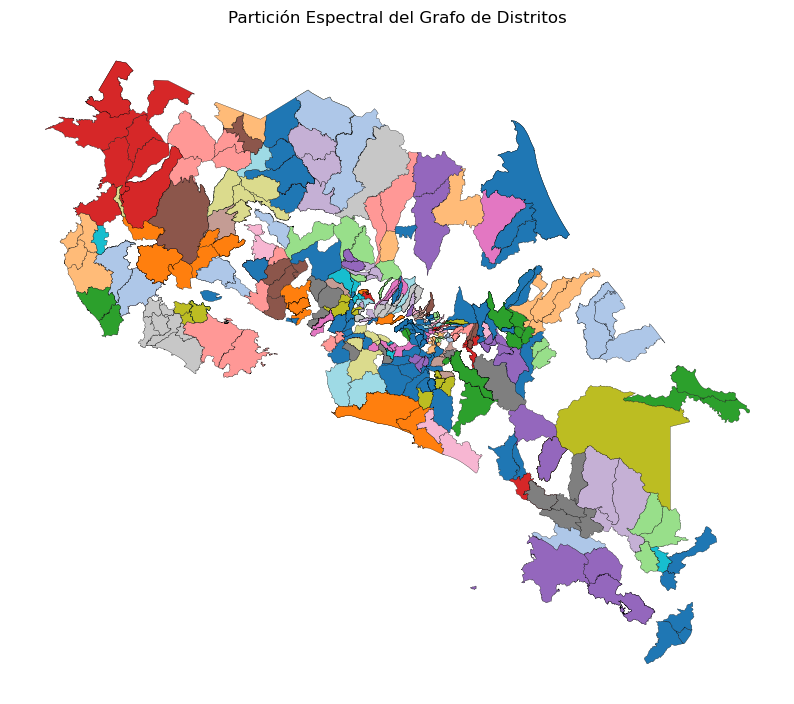

In [602]:
# Visualización del resultado
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='Distrito_Spectral', cmap='tab20', linewidth=0.2, edgecolor='black', ax=ax)
plt.title('Partición Espectral del Grafo de Distritos')
plt.axis('off')
plt.show()

## Trabajemos con una tabla de un sitio web para evitar eliminar distritos 

In [611]:
import pandas as pd

# Leer todas las tablas de la página
url = "https://es.wikipedia.org/wiki/Anexo:Distritos_de_Costa_Rica"
tablas = pd.read_html(url)

# Mostrar el número de tablas encontradas
print(f"Se encontraron {len(tablas)} tablas en la página.")

# Inspeccionar las primeras filas de cada tabla para identificar la deseada
for i, tabla in enumerate(tablas):
    print(f"\nTabla {i}:")
    print(tabla.head())


Se encontraron 2 tablas en la página.

Tabla 0:
    0                                                  1
0 NaN  Se ha sugerido que Anexo:Distritos de la provi...

Tabla 1:
  Provincia    Cantón  Distrito Código Postal Área (km²) Población             \
  Provincia    Cantón  Distrito Código Postal Área (km²) Est. 2022 Censo 2011   
0  San José  San José    Carmen         10101      149.0      2946       2702   
1  San José  San José    Merced         10102      220.0    15 408     12 257   
2  San José  San José  Hospital         10103      332.0    24 030     19 270   
3  San José  San José  Catedral         10104      237.0    15 682     12 936   
4  San José  San José    Zapote         10105      286.0    21 990     18 679   

                                       
  Censo 2000 Cambio Censal Dens. 2011  
0       3360        −19,6%      18381  
1     13 565         −9,6%      56484  
2     24 175        −20,3%      58394  
3     15 341        −15,7%      55047  
4     20 753        

In [626]:
# Asignar la tabla deseada a un DataFrame
df_distritos = tablas[1]

# Mostrar las primeras filas del DataFrame
print(df_distritos.head())

  Provincia    Cantón  Distrito  Código Postal  Área (km²) Población  \
0  San José  San José    Carmen          10101       149.0      2946   
1  San José  San José    Merced          10102       220.0    15 408   
2  San José  San José  Hospital          10103       332.0    24 030   
3  San José  San José  Catedral          10104       237.0    15 682   
4  San José  San José    Zapote          10105       286.0    21 990   

  Población Población Población Población  
0      2702      3360    −19,6%     18381  
1    12 257    13 565     −9,6%     56484  
2    19 270    24 175    −20,3%     58394  
3    12 936    15 341    −15,7%     55047  
4    18 679    20 753    −10,0%     65084  
